# SOC LEAFs Grassland Supporting calculations
This notebook documents the generation of grassland base data needed to run RothC model and serves as a complement to [SOC_LEAFs_Baseline](../documentation/SOC_LEAFs_Baseline.ipynb) notebook. Soil & Weather data has already been generated to run crop commodities and thus it's not explained here.

## Step 1 - Data Download
### 1) Residues
As land use has already been determined, the next step is to estimate annual and monthly residue production. Annual residue production is per climate zone is obtained from Table 6.4 of the [2006 IPCC](https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_06_Ch6_Grassland.pdf). Due to the high error range (75%), a random value is generated per UHTH pixel during each run using a normal distribution. 

Residues production values have been summarized in [grassland_residues_IPCC](../data/grasslands/grassland_residues_IPCC.xlsx) excel spreadsheet, which have been mapped into FAO GAEZ climate zones.

As there is a single grassland land use map, residue production needs to be generated crossing land use, climate zones, and table residue data. This is done as follows, and is done on each iteration of RothC:

In [26]:
# modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import rasterio
import importlib
from rasterio.enums import Resampling
import sbtn_leaf.map_plotting as mp
import polars as pl
import geopandas as gpd
import sbtn_leaf.cropcalcs as cropcalcs
import sbtn_leaf.map_plotting as mp
import sbtn_leaf.map_calculations as mc
import requests
from pathlib import Path
from typing import List, Optional, Union

In [ ]:
# data
grassland_residue_raster = cropcalcs.generate_grassland_residue_map()

Examining...

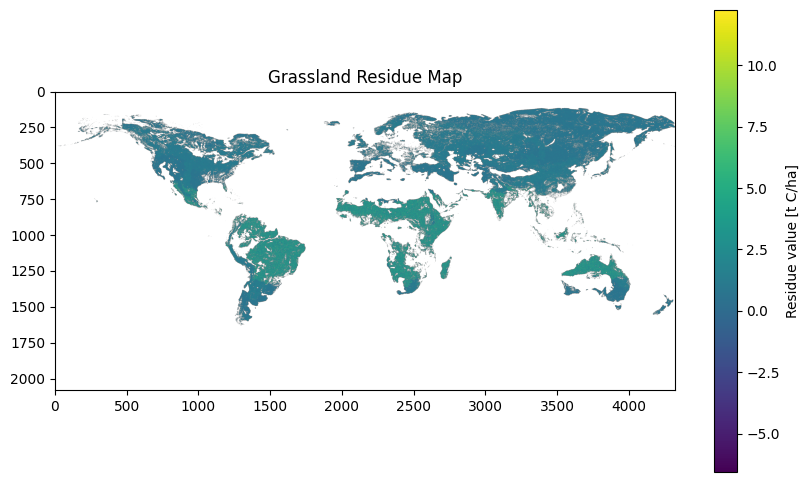

In [ ]:
plt.figure(figsize=(10, 6))
img = plt.imshow(grassland_residue_raster.squeeze(), cmap='viridis')
plt.colorbar(img, label='Residue value [t C/ha]')
plt.title('Grassland Residue Map')
plt.show()


### 2 - Shitty calculations
So now we have to calculate how much shit goes into the grass, the most fun part of all SOC calculations...

To calculate dung depositions into each pixel, the following equation is applied:
$$ Dung_{p} = \sum_a {LSU_{p,a}\cdot CD_{a,r}} $$

Where:
- $\textstyle Dung_{p}$ represents the annual carbon input from dung deposition in pixel $\textstyle p$
- $\textstyle LSU_{p,a}$ is the 10-year average amount of livestock units of animal a (cattle, sheep, and goats)
- $\textstyle CD_{a,r}$ is the carbon input from dung depositions from animal $\textstyle a$ in region $\textstyle r$

LSU is obtained from FAO's [Gridded livestock density v4](https://data.apps.fao.org/catalog/dataset/9d1e149b-d63f-4213-978b-317a8eb42d02), while $\textstyle CD_{a,r}$ is calculated from [IPCC 2019](https://www.ipcc-nggip.iges.or.jp/public/2019rf/pdf/4_Volume4/19R_V4_Ch10_Livestock.pdf) and [FAO's Farmer’s Compost Handbook—Experiences in Latin America](https://openknowledge.fao.org/server/api/core/bitstreams/0658b4e0-53e3-4ed7-89d0-ff351bec1dff/content) C:N ratios.

#### 2.1 Average Livestock units
Two sets of values are calculated: a) average livestock density (number of heads per hectare) and b) prediction uncertainty. A 10-year average between 2011 and 2021 is calculated, as 2016 is SOC baseline year and represents the midpoint.

##### Data download
Cattle, goats and sheeps data can be downloaded from [here](https://data.apps.fao.org/catalog/dataset/9d1e149b-d63f-4213-978b-317a8eb42d02), and has been stored in `data/grassland/livestock/` folder.

These maps represent the estimated heads per $\textstyle km^2$ for 2020 at 0.083°, or roughly 10km, which is the same as the UHTH master grid.

In [72]:
fao_cattle_density_fp = "../data/grasslands/livestock/GLW4-2020.D-DA.CTL.tif"

Inspecting cattle

In [73]:
mp.inspect_raster(fao_cattle_density_fp)

File: ../data/grasslands/livestock/GLW4-2020.D-DA.CTL.tif
Driver: GTiff
Width, Height: 4320, 2160
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-89.99999999999994, right=179.9999999999999, top=90.0)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 3654.19775390625
  Mean Value: 9.734325408935547
  Standard Deviation: 25.848939895629883


Raster has 1,806,062 unique values. Min: 0.00. Max: 126.29
Using quantiles
All positives route (quantiles)


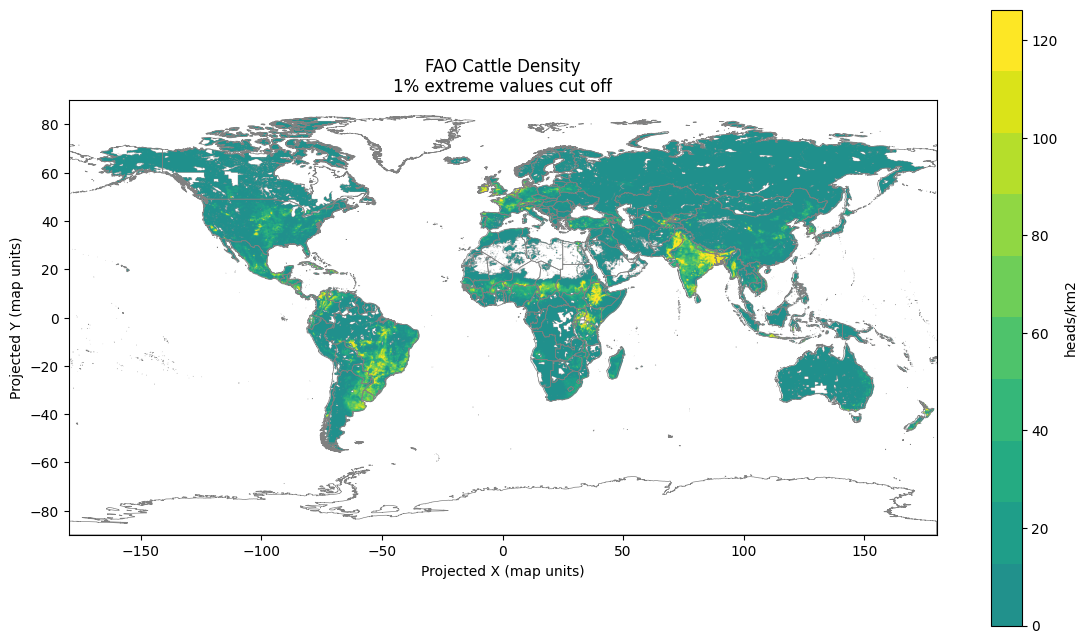

In [86]:
mp.plot_raster_on_world_extremes_cutoff(fao_cattle_density_fp, "FAO Cattle Density\n1% extreme values cut off", label_title="heads/km2", eliminate_zeros=True, perc_cutoff=1, quantiles=10)

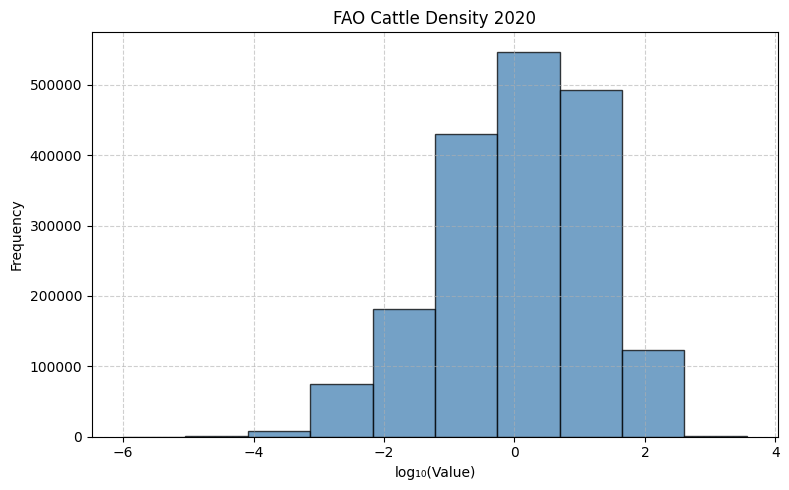

In [87]:
mp.plot_raster_histogram(fao_cattle_density_fp, mask_zeros=True, bins=10, log_scale=True, title="FAO Cattle Density 2020")

Looks ok, with the mode around 1 head of cattle per km2, and a few between 10-100, and very few over 1,000.

Checking goats and sheeps

In [90]:
fao_sheep_density_fp = "../data/grasslands/livestock/GLW4-2020.D-DA.SHP.tif"
fao_goat_density_fp = "../data/grasslands/livestock/GLW4-2020.D-DA.GTS.tif"

In [91]:
mp.inspect_raster(fao_goat_density_fp)

File: ../data/grasslands/livestock/GLW4-2020.D-DA.GTS.tif
Driver: GTiff
Width, Height: 4320, 2160
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-89.99999999999994, right=179.9999999999999, top=90.0)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: -3.4028234663852886e+38

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 0.0
  Max Value: 2608.393798828125
  Mean Value: 6.943488121032715
  Standard Deviation: 29.45149040222168


Raster has 1,715,369 unique values. Min: 0.00. Max: 129.18
Using quantiles
All positives route (quantiles)


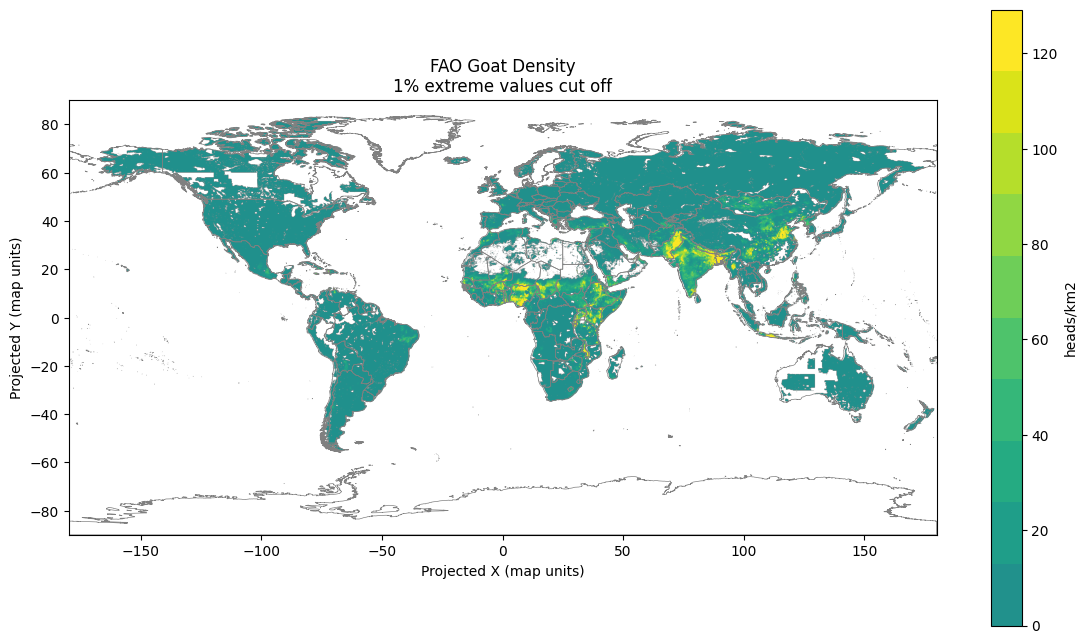

In [92]:
mp.plot_raster_on_world_extremes_cutoff(fao_goat_density_fp, "FAO Goat Density\n1% extreme values cut off", label_title="heads/km2", eliminate_zeros=True, perc_cutoff=1, quantiles=10)

Raster has 1,721,868 unique values. Min: 0.00. Max: 137.48
Using quantiles
All positives route (quantiles)


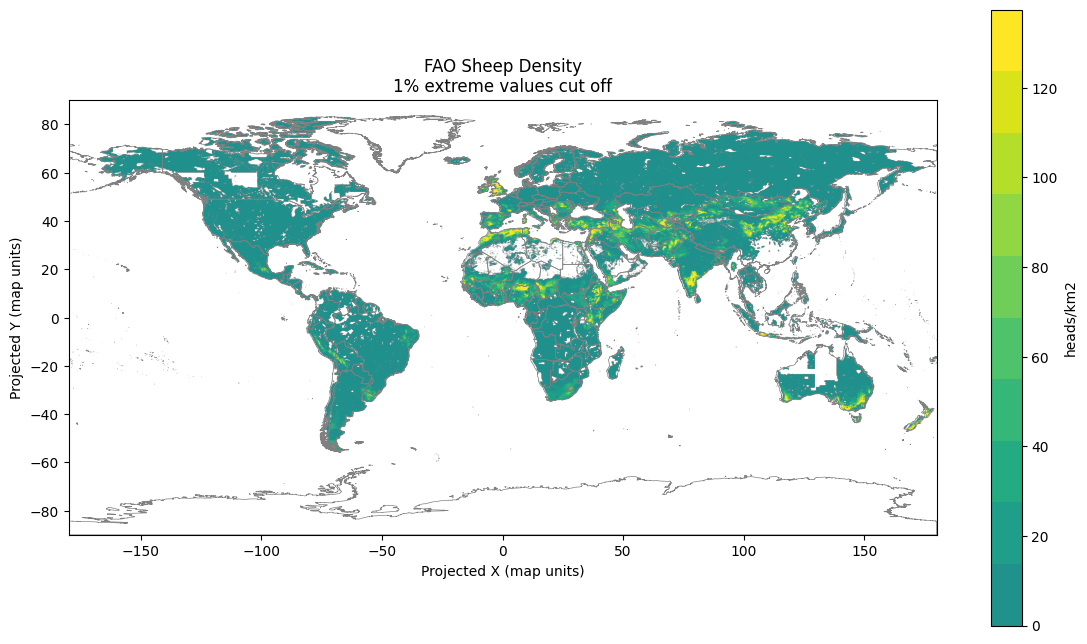

In [93]:
mp.plot_raster_on_world_extremes_cutoff(fao_sheep_density_fp, "FAO Sheep Density\n1% extreme values cut off", label_title="heads/km2", eliminate_zeros=True, perc_cutoff=1, quantiles=10)

#### Harmonizing into master grid

Loading the grid

In [94]:
master_grid_fp = "../data/world_maps/soc_uht_map.tif"

Resampling each layer

In [96]:
mc.resample_to_match(fao_cattle_density_fp, master_grid_fp, "../data/grasslands/livestock/cattle_density_uhth.tif", Resampling.bilinear)

Cattle output...

Raster has 1,848,954 unique values. Min: 0.00. Max: 125.01
Using quantiles
All positives route (quantiles)


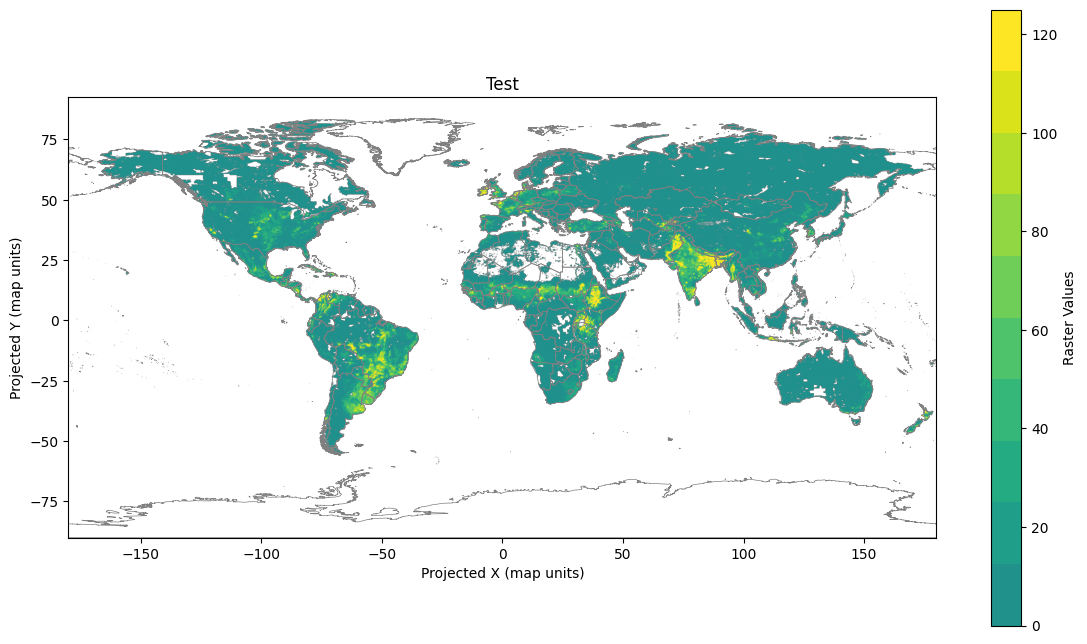

In [98]:
mp.plot_raster_on_world_extremes_cutoff("../data/grasslands/livestock/cattle_density_uhth.tif", "Test", perc_cutoff = 1, quantiles = 10, eliminate_zeros=True)

#### Clipping into land use
Now a raster where grassland is possible is generated per animal.

Loading the grassland land use raster...

In [100]:
grassland_lu_fp = "../data/land_use/lu_Grassland.tif"

Raster has 1 unique values. Min: 1.00. Max: 1.00


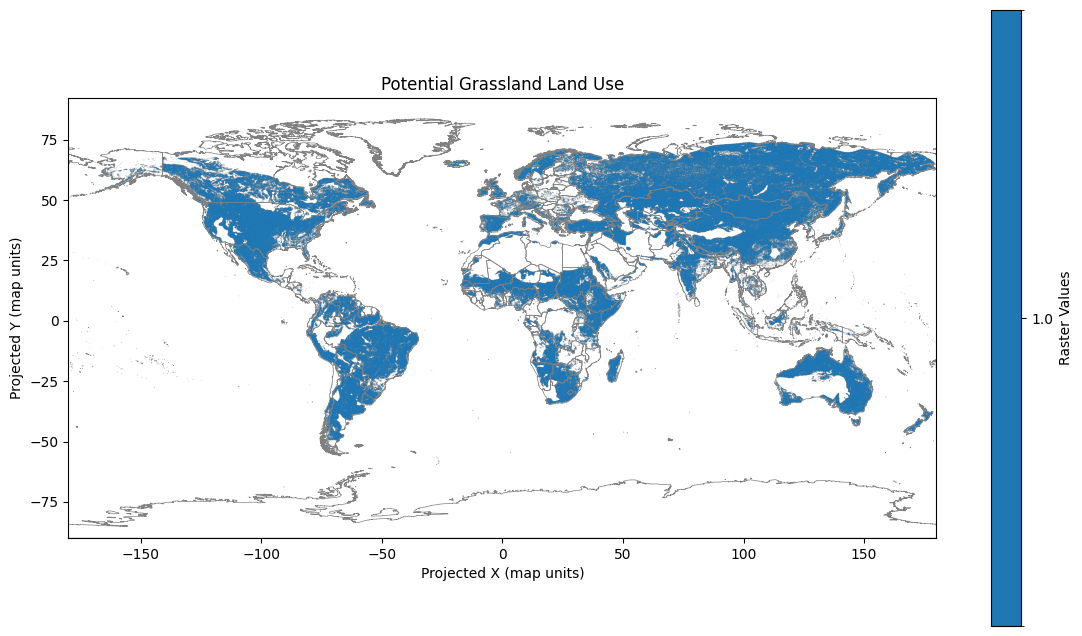

In [101]:
mp.plot_raster_on_world_extremes_cutoff(grassland_lu_fp, "Potential Grassland Land Use", eliminate_zeros=True)

Now as the land use raster has a value of either 1 or 0, each animal raster can be simply multiplied  by the land use raster to obtain the needed data layers

In [105]:
mc.multiply_rasters([grassland_lu_fp, "../data/grasslands/livestock/cattle_density_uhth.tif"], "../data/grasslands/livestock/grassland_cattle.tif")

Raster saved into ../data/grasslands/livestock/grassland_cattle.tif


array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], shape=(2083, 4320))

Checking the output

Raster has 1,212,585 unique values. Min: 0.00. Max: 3,654.20
Using quantiles
All positives route (quantiles)


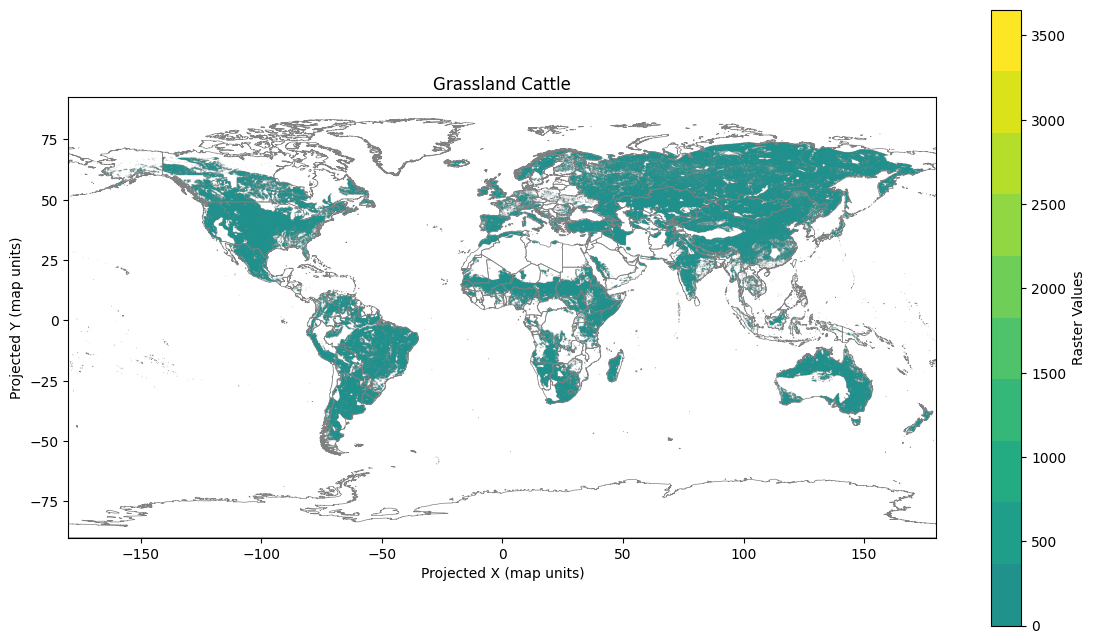

In [109]:
mp.plot_raster_on_world_extremes_cutoff("../data/grasslands/livestock/grassland_cattle.tif", "Grassland Cattle", perc_cutoff=0, quantiles=10, eliminate_zeros=True)

Which looks ok. Proceeding with the other animals...

In [110]:
mc.multiply_rasters([grassland_lu_fp, "../data/grasslands/livestock/goat_density_uhth.tif"], "../data/grasslands/livestock/grassland_goat.tif")
mc.multiply_rasters([grassland_lu_fp, "../data/grasslands/livestock/sheep_density_uhth.tif"], "../data/grasslands/livestock/grassland_sheep.tif")

Raster saved into ../data/grasslands/livestock/grassland_goat.tif
Raster saved into ../data/grasslands/livestock/grassland_sheep.tif


array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], shape=(2083, 4320))

#### Calculating C from dung input
Now that livestock density has been calculated, maps need to be generated by assigning annual C excretion rates. As this are given by continent, mostly, a mapping needs to be done.

First, loading the world shapefile

In [113]:
world_shp = gpd.read_file("../data/world_maps/high_res/ne_10m_admin_0_countries.shp")

Selecting useful columns

In [121]:
bigregions_cols = ["CONTINENT", "REGION_UN", "SUBREGION", "REGION_WB"]
other_needed_cols = ["ADMIN", "geometry"]

In [153]:
world_br_gdf = world_shp[other_needed_cols + bigregions_cols]

Now assigning a dung_region:

In [154]:
# Country lists for some IPCC regions
east_eur_countries = [
    'Ukraine',
    'Belarus',
    'Lithuania',
    'Russia',
    'Czechia',
    'Estonia',
    'Latvia',
    'North Macedonia',
    'Albania',
    'Kosovo',
    'Romania',
    'Hungary',
    'Slovakia',
    'Poland',
    'Republic of Serbia',
    'Croatia',
    'Slovenia',
    'Bulgaria',
    'Montenegro',
    'Bosnia and Herzegovina',
    'Moldova'
]

wester_eur_countries = [
    'France',
    'Germany',
    'Norway',
    'Sweden',
    'Finland',
    'Luxembourg',
    'Belgium',
    'Spain',
    'Denmark',
    'Ireland',
    'United Kingdom',
    'Greece',
    'Austria',
    'Italy',
    'Switzerland',
    'Netherlands',
    'Liechtenstein',
    'San Marino',
    'Monaco',
    'Andorra',
    'Portugal',
    'Gibraltar',
    'Vatican',
    'Iceland',
    'Malta',
    'Jersey',
    'Guernsey',
    'Isle of Man',
    'Aland',
    'Faroe Islands'
]

middle_east_countries = [
    'Israel',
    'Palestine',
    'Lebanon',
    'Syria',
    'Oman',
    'United Arab Emirates',
    'Iraq',
    'Iran',
    'Qatar',
    'Saudi Arabia',
    'Kuwait',
    'Jordan',
    'Egypt',
    'Yemen',
    'Bahrain'
]

In [160]:
# masks
m_india   = world_br_gdf["ADMIN"].eq("India")
m_easteu  = world_br_gdf["ADMIN"].isin(east_eur_countries)
m_westeu  = world_br_gdf["ADMIN"].isin(wester_eur_countries)  # keep your var name
m_me      = world_br_gdf["ADMIN"].isin(middle_east_countries)
m_na      = world_br_gdf["SUBREGION"].eq("Northern America")
m_latam   = world_br_gdf["SUBREGION"].isin(["South America","Central America", "Caribbean"])
m_asia    = world_br_gdf["REGION_UN"].eq("Asia")
m_africa  = world_br_gdf["REGION_UN"].eq("Africa")
m_oceania = world_br_gdf["REGION_UN"].eq("Oceania")

rules = [
    ("India",           m_india,   1),
    ("Eastern Europe",  m_easteu,  2),
    ("Western Europe",  m_westeu,  3),
    ("Middle East",     m_me,      4),
    ("North America",   m_na,      5),
    ("LATAM",           m_latam,   6),
    ("Asia",            m_asia,    7),
    ("Africa",          m_africa,  8),
    ("Oceania",         m_oceania, 9),
]


Assigning:

In [161]:
# defaults
world_br_gdf["dung_region"] = "unassigned"
world_br_gdf["dung_region_values"] = -1

c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [162]:
# assigning
for label, mask, code in rules:
    unassigned = world_br_gdf["dung_region"].eq("unassigned")
    take = mask & unassigned
    world_br_gdf.loc[take, "dung_region"] = label
    world_br_gdf.loc[take, "dung_region_values"] = code

Now each grassland pixel needs to be assigned a dung_value_region

In [210]:
output_dung_fp = "../data/grasslands/livestock/uhth_dung_regions.tif"

In [211]:
mc.rasterize_shapefile_to_target_raster(gdf=world_br_gdf, raster_filepath=grassland_lu_fp, value_column="dung_region_values", output_path=output_dung_fp)

Opening target raster
Projecting shapefile to target raster
Rasterizing shapefile
Saving raster


Raster has 10 unique values. Min: -1.00. Max: 9.00


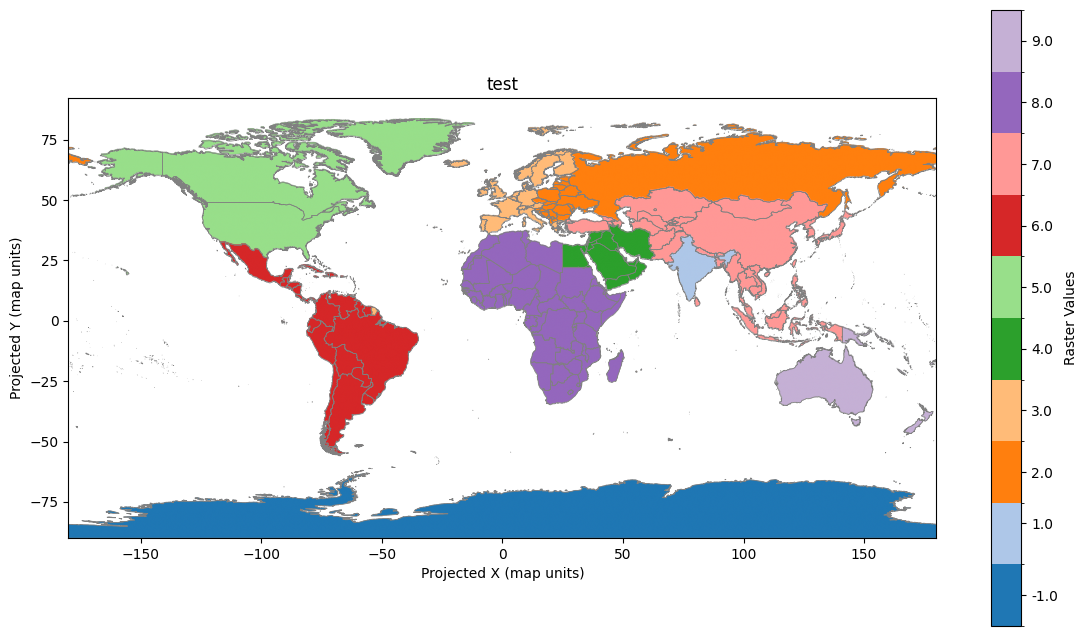

In [212]:
mp.plot_raster_on_world_extremes_cutoff(output_dung_fp, "test", eliminate_zeros=True, perc_cutoff=0)

Now masking to grassland potential pixels

In [213]:
with rasterio.open(grassland_lu_fp) as grass_src:
    grass_lu = grass_src.read(1)
    src_nd   = grass_src.nodata

with rasterio.open(output_dung_fp) as dung_src:
    dung_region = dung_src.read(1)
    dung_nodata = dung_src.nodata
    dung_profile = dung_src.profile

grass_mask = (grass_lu == 1) & (grass_lu != src_nd) & (~np.isnan(grass_lu))
dung_mask = (dung_region != dung_nodata) & (~np.isnan(dung_region))
valid = grass_mask & dung_mask

dung_region = np.where(valid, dung_region, np.nan)

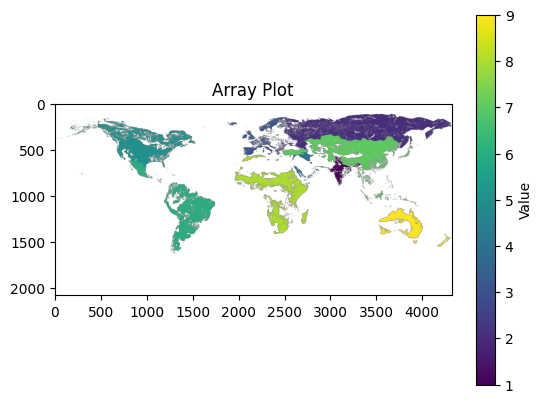

In [214]:
plt.imshow(dung_region, cmap="viridis")   # or "gray", "terrain", etc.
plt.colorbar(label="Value")
plt.title("Array Plot")
plt.show()


Looks ok, saving.

In [216]:
# Updating output profile
grassland_dung_profile = dung_profile.copy()
out_nodata = -32768
grassland_dung_profile.update(
    dtype="int16",
    count=1,
    nodata=out_nodata,
    compress="lzw"
)

grassland_dung_fp = "../data/grasslands/livestock/grassland_dung_regions.tif"
with rasterio.open(grassland_dung_fp, "w", **grassland_dung_profile) as dst:
    # replace NaN or invalid pixels with nodata 
    out_arr = np.where(np.isnan(dung_region), out_nodata, dung_region).astype("int16")
    dst.write(out_arr, 1)

Inspecting...

Raster has 9 unique values. Min: 1.00. Max: 9.00


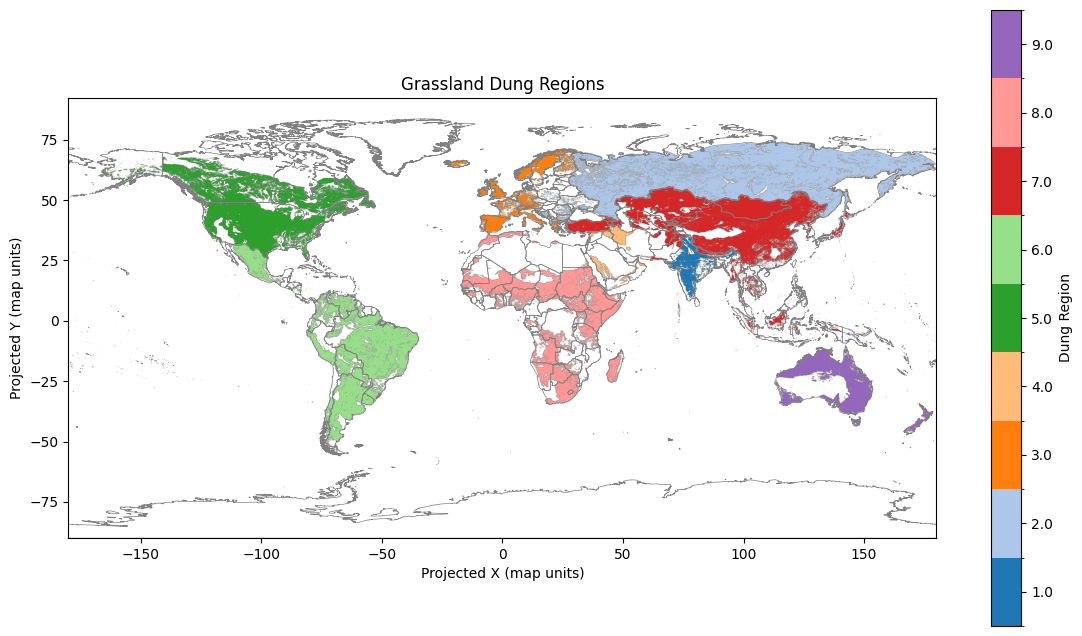

In [257]:
mp.plot_raster_on_world_extremes_cutoff(grassland_dung_fp, "Grassland Dung Regions", label_title="Dung Region",perc_cutoff=0, eliminate_zeros=True)

Looks good.

#### Dung Carbon Excretion Calculations
With all the different data points processed, it's finally time to calculate dung carbon excretions

In [261]:
importlib.reload(cropcalcs)

Could not determine dtype for column 1, falling back to string


<module 'sbtn_leaf.cropcalcs' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\cropcalcs.py'>

In [262]:
cattle_dung = cropcalcs.calculate_carbon_dung("cattle_other")

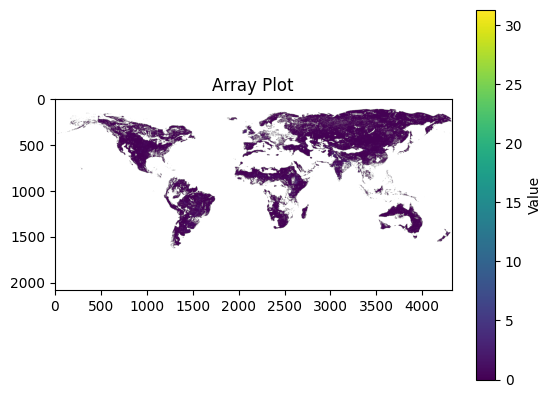

In [268]:
plt.imshow(cattle_dung["cattle_other"], cmap="viridis")   # or "gray", "terrain", etc.
plt.colorbar(label="Value")
plt.title("Array Plot")
plt.show()

# 2 - Run RothC
All other information has already been generated for annual crops. 

Roth C for forest can be run as

In [2]:
import sbtn_leaf.RothC_Raster as rothc

In [4]:
import importlib

In [22]:
importlib.reload(rothc)
importlib.reload(cropcalcs)

Could not determine dtype for column 1, falling back to string
Could not determine dtype for column 8, falling back to string
Could not determine dtype for column 9, falling back to string


<module 'sbtn_leaf.cropcalcs' from 'C:\\Users\\loyola\\OneDrive - World Wildlife Fund, Inc\\Documents\\203. Python projects\\SBTN_Test\\src\\sbtn_leaf\\cropcalcs.py'>

In [10]:
# Extra fp needed
lu_forest_fp = "../data/land_use/lu_Needleleaf_Evergreen_Cold_temperate_moist.tif"
age_fp = "../data/forest/age/Needleleaf_Evergreen_Boreal_moist_age.tif"

In [24]:
forest_soc_test = rothc.run_RothC_forest(
    lu_fp=lu_forest_fp,
    forest_type="NEEV",
    weather_type="Cold temperate moist",
    n_years=5,
    save_folder="../LEAFs",
    age_fp=age_fp,
    evap_fp="../data/soil_weather/uhth_pet_locationonly.tif",
    data_description="Forest Test"
)

Loading environmental data...
Loading forest data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:69: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 60/60 [02:26<00:00,  2.44s/it]


Checking results...

In [25]:
forest_soc_test_fp = '../LEAFs/NEEV_None_5y_SOC.tif'

In [26]:
mp.inspect_raster(forest_soc_test_fp)

File: ../LEAFs/NEEV_None_5y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 6
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: Forest Test
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.81576681137085
  Max Value: 164.99652099609375
  Mean Value: 56.361671447753906
  Standard Deviation: 21.169614791870117

Band 2:
  Data Type: float32
  Min Value: 9.164597511291504
  Max Value: 162.54275512695312
  Mean Value: 57.410484313964844
  Standard Deviation: 20.584999084472656

Band 3:
  Data Type: float32
  Min Value: 11.680132865905762
  Max Value: 160.43746948242188
  Mean Value: 59.296138763427734
  Standard Deviation: 20.23917007446289

Band 4:
  Data Type

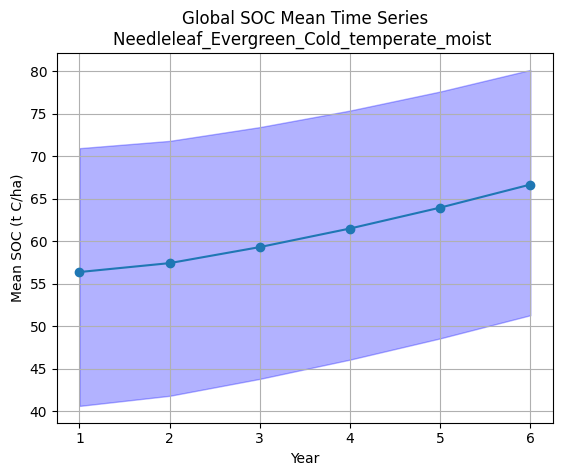

In [ ]:
mp.plot_multiband_raster_timesires(forest_soc_test_fp, "Global SOC Mean Time Series\nNeedleleaf_Evergreen_Cold_temperate_moist", show_iq=True)

Raster has 193,878 different values. Min: 32.94. Max: 109.09
Using quantiles
All positives route


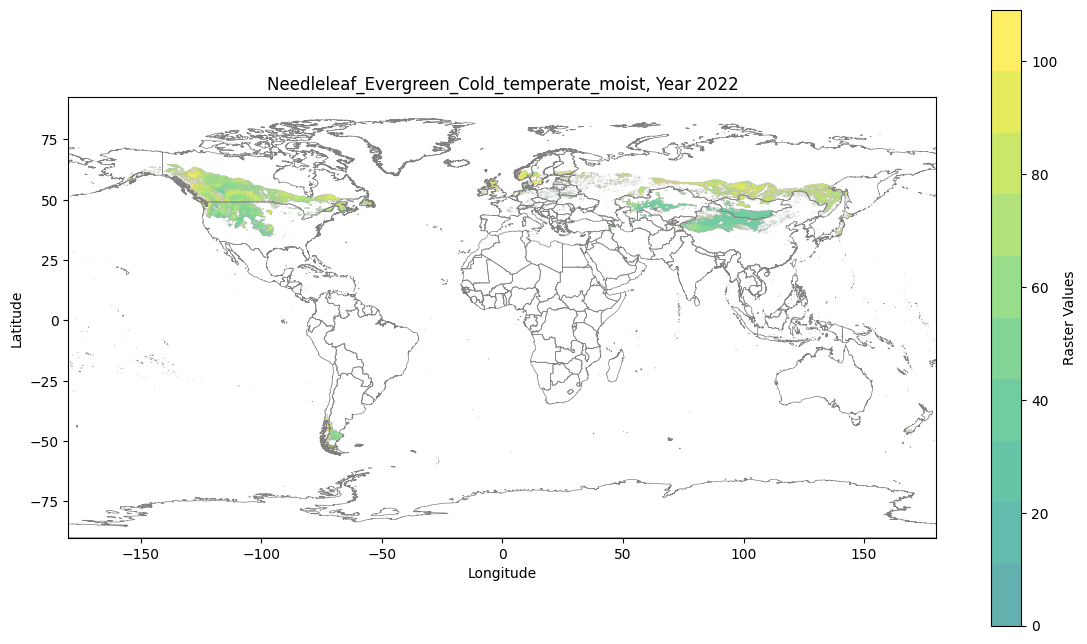

In [ ]:
mp.plot_raster_on_world_extremes_cutoff(forest_soc_test_fp, "Needleleaf_Evergreen_Cold_temperate_moist, Year 2022", raster_band=6, perc_cutoff=1, quantiles=10)

In [33]:
pct_change = rothc.calcuate_annual_perc_changes(forest_soc_test_fp)

Raster has 190,136 different values. Min: 0.23. Max: 71.81
Using quantiles
All positives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist'}, xlabel='Longitude', ylabel='Latitude'>)

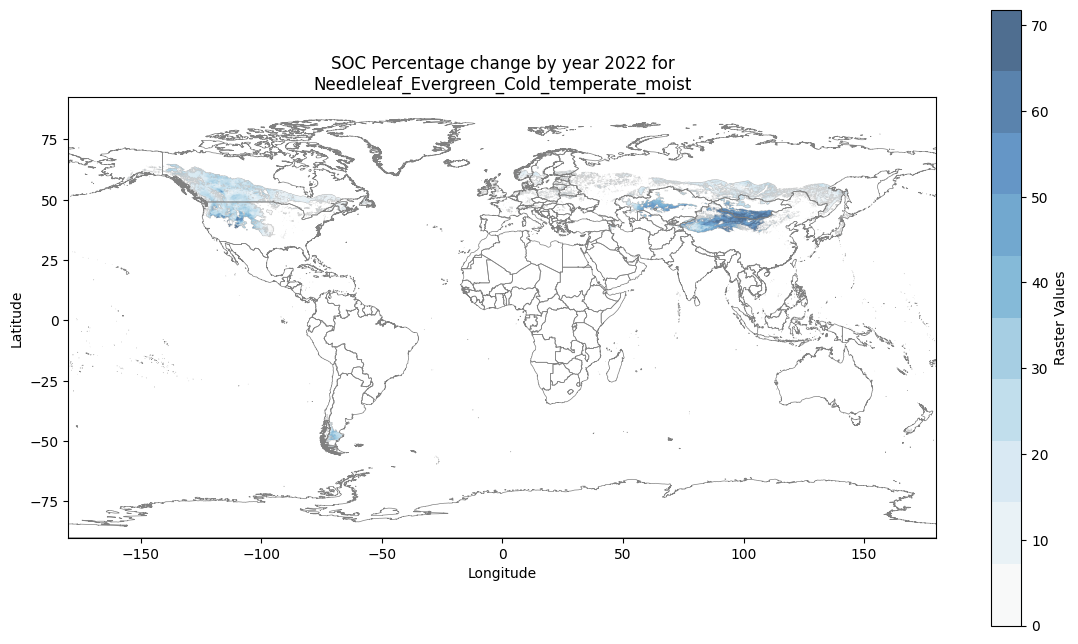

In [44]:
mp.plot_da_on_world_extremes_cutoff(pct_change, "SOC Percentage change by year 2022 for\nNeedleleaf_Evergreen_Cold_temperate_moist", band=5, cmap="RdBu", quantiles=10) # type: ignore